## for coreference resolution

In [ ]:
!pip install -U tensorflow-text==2.10.0

In [ ]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

english_sentences = ["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."]
italian_sentences = ["cane", "I cuccioli sono carini.", "Mi piace fare lunghe passeggiate lungo la spiaggia con il mio cane."]
japanese_sentences = ["犬", "子犬はいいです", "私は犬と一緒にビーチを散歩するのが好きです"]

In [ ]:
url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
embed = hub.load(url)

# 埋め込みの計算
en_result = embed(english_sentences)
it_result = embed(italian_sentences)
ja_result = embed(japanese_sentences)

In [ ]:
!pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl
!pip show en_coreference_web_trf

In [7]:
import spacy
nlp = spacy.load("en_coreference_web_trf")
doc = nlp("John Smith called from New York, he says it's raining in the city.")
# print("=== word clusters ===")
# word_clusters = [val for key, val in doc.spans.items() if key.startswith("coref_head")]
# for cluster in word_clusters:
#     print(cluster)
# check the expanded clusters
print("=== full clusters ===")
full_clusters = [val for key, val in doc.spans.items() if key.startswith("coref_cluster")]
for cluster in full_clusters:
    print(cluster)
    first_span = cluster[0]
    for mention_span in list(cluster)[1:]:
        print(mention_span)
        print(mention_span[0])
        print(mention_span[0].whitespace_)
        print(mention_span[0].idx)

    

=== full clusters ===
[John Smith, he]
he
he
 
33
[New York, the city]
the city
the
 
57


In [ ]:
def coreference_resolution(
        sentences,
        progress_bar= False,
    ) :
        """
        coreference resolution using spaCy (v0.6.1)
        Args:
                sentences: list of sentences
                progress_bar: print a progress bar (default is False)
                model_url: set the url model
        Returns:
            List of processed statements
        """
        try:
            import spacy

            nlp = spacy.load("en_coreference_web_trf")

        except ModuleNotFoundError:
            print("Please install spacy")
            raise
        except OSError:
            print("Please download 'en_coreference_web_tf' pipeline")
            raise

        def resolve_references(doc) -> str:
            token_mention_dict = {}
            output_string = ""
            clusters = [val for key, val in doc.spans.items() if key.startswith("coref_clusters")]
            for cluster in clusters:
                first_span = cluster[0]
                for mention_span in list(cluster)[1:]:
                    token_mention_dict[mention_span[0].idx] = first_span.text + mention_span[0].whitespace_
                    for token in mention_span[1:]:
                        token_mention_dict[token.idx] = ""
            for token in doc:
                if token.idx in token_mention_dict:
                    output_string += token_mention_dict[token.idx]
                else:
                    output_string += token.text + token.whitespace_
            return output_string

        if progress_bar:
            disable = False
        else:
            disable = True
        print("resolving reference with coref output ...")
        coreference_output_list = []
        for sentence in tqdm(sentences, disable=disable):
            doc = nlp(sentence)
            coreference_output_list.append(resolve_references(doc))

        return coreference_output_list

from ast import literal_eval
from io import StringIO

import pandas as pd
import requests


def list_datasets():
    s = """
    List of available datasets:
    Trump Tweet Archive
    - function call: load_trump_data()
    - format: 'raw', 'split_sentences', 'srl_res'
    - allennlp version: 0.9
    - srl model: srl-model-2018.05.25.tar.gz
    """

    return s


def load_trump_data(format: str):
    """
    Load processed tweets from the Trump Tweet Archives (https://www.thetrumparchive.com/).
    Args:
        file: either 'raw' (i.e. dataframe with raw text), 'split_sentences' (i.e. result from split_sentences()) or 'srl_res' (i.e. result from run_srl())
    Returns:
        The desired object.
    """

    if format == "raw":
        r = requests.get(
            "https://www.dropbox.com/s/lxqz454n29iqktn/trump_archive.csv?dl=1"
        )
        r = pd.read_csv(StringIO(r.text))
    elif format == "split_sentences":
        r = requests.get(
            "https://www.dropbox.com/s/coh4ergyrjeolen/split_sentences.json?dl=1"
        )
        r = literal_eval(r.text)
    elif format == "srl_res":
        r = requests.get("https://www.dropbox.com/s/54lloy84ka8mycp/srl_res.json?dl=1")
        r = literal_eval(r.text)
    else:
        raise ValueError(
            "file argument should either be raw, split_sentences or srl_res"
        )

    return r

## for test function

In [1]:
import os
os.chdir('/Users/shim-kojio/Desktop/relatio/')

In [ ]:
phrases = [
    'Wolves eat rabbits.', 
    'The wolf eats the rabbit.', 
    'Some wolves eat vegetables, but most wolves do not eat vegetables.',
    'Trees provide us with wood.',
    'President Obama made great speeches. Black men and women fight for their rights.',
    'Black men and women fight for their rights.'
]

import pandas as pd

df = pd.DataFrame(phrases)

df['id'] = df.index

df.columns = ['doc', 'id']

In [ ]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
df.shape

In [ ]:
import numpy as np
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
cos_sim(embeddings[0],embeddings[2])

## for relatio args

In [1]:
import os
os.chdir('/Users/shim-kojio/Desktop/relatio/')

In [2]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")
from relatio import Preprocessor

import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = list(nlp.Defaults.stop_words)

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = stop_words,
    n_process = -1,
    batch_size = 100
)

df_split = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(df_split['sentence'], progress_bar=True)

2023-01-10 13:56:52.565576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Splitting into sentences...


100%|██████████| 32323/32323 [01:57<00:00, 274.45it/s]


In [46]:
df_split.loc[0,'sentence']

'Republicans and Democrats have both created our economic problems.'

In [52]:
srl_res[0]['verbs']

[{'verb': 'have',
  'description': 'Republicans and Democrats [V: have] both created our economic problems .',
  'tags': ['O', 'O', 'O', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O']},
 {'verb': 'created',
  'description': '[ARG0: Republicans and Democrats] have both [V: created] [ARG1: our economic problems] .',
  'tags': ['B-ARG0',
   'I-ARG0',
   'I-ARG0',
   'O',
   'O',
   'B-V',
   'B-ARG1',
   'I-ARG1',
   'I-ARG1',
   'O']}]

In [4]:
from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    progress_bar = True
)

for d in roles[0:5]: print(d)

Extracting semantic roles...


100%|██████████| 63723/63723 [00:03<00:00, 16002.05it/s]

{'B-V': 'have'}
{'ARG0': 'Republicans and Democrats', 'ARG1': 'our economic problems', 'B-V': 'created'}
{'ARG1': 'I', 'ARG2': 'thrilled to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST', 'B-V': 'was'}
{'ARG1': 'I', 'ARG2': 'back in the Great city of Charlotte , North Carolina with , respect our laws , and always put AMERICA FIRST', 'B-V': 'be'}
{'ARG1': 'Patriots', 'B-V': 'hardworking'}


In [61]:
len(roles)

147618

In [62]:
srl_res[0]

{'verbs': [{'verb': 'have',
   'description': 'Republicans and Democrats [V: have] both created our economic problems .',
   'tags': ['O', 'O', 'O', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O']},
  {'verb': 'created',
   'description': '[ARG0: Republicans and Democrats] have both [V: created] [ARG1: our economic problems] .',
   'tags': ['B-ARG0',
    'I-ARG0',
    'I-ARG0',
    'O',
    'O',
    'B-V',
    'B-ARG1',
    'I-ARG1',
    'I-ARG1',
    'O']}],
 'words': ['Republicans',
  'and',
  'Democrats',
  'have',
  'both',
  'created',
  'our',
  'economic',
  'problems',
  '.']}

In [59]:
roles[:10]

[{'B-V': 'have'},
 {'ARG0': 'Republicans and Democrats',
  'ARG1': 'our economic problems',
  'B-V': 'created'},
 {'ARG1': 'I',
  'ARG2': 'thrilled to be back in the Great city of Charlotte , North Carolina with thousands of hardworking American Patriots who love our Country , cherish our values , respect our laws , and always put AMERICA FIRST',
  'B-V': 'was'},
 {'ARG1': 'I',
  'ARG2': 'back in the Great city of Charlotte , North Carolina with , respect our laws , and always put AMERICA FIRST',
  'B-V': 'be'},
 {'ARG1': 'Patriots', 'B-V': 'hardworking'},
 {'ARG0': 'thousands of hardworking American Patriots who',
  'ARG1': 'our Country',
  'B-V': 'love'},
 {'ARG0': 'thousands of hardworking American Patriots who',
  'ARG1': 'our values',
  'B-V': 'cherish'},
 {'ARG1': 'our laws', 'B-V': 'respect'},
 {'ARG0': 'who', 'ARG1': 'AMERICA FIRST', 'B-V': 'put'},
 {'ARG1': 'you', 'ARG2': 'for a wonderful evening', 'B-V': 'Thank'}]

In [5]:
postproc_roles = p.process_roles(roles, 
                                 dict_of_pos_tags_to_keep = {
                                     "ARG0": ['PRON', 'NOUN', 'PROPN'],
                                     "B-V": ['VERB'],
                                     "ARG1": ['NOUN', 'PROPN', 'PRON']
                                 }, 
                                 max_length = 50,
                                 progress_bar = True,
                                 output_path = 'postproc_roles.json')

for d in postproc_roles[0:5]: print(d)

Cleaning phrases for role ARG0...


100%|██████████| 53100/53100 [00:47<00:00, 1116.79it/s]


Cleaning phrases for role B-V...


100%|██████████| 136367/136367 [01:44<00:00, 1299.37it/s]


Cleaning phrases for role B-ARGM-MOD...


100%|██████████| 12891/12891 [00:10<00:00, 1255.56it/s]


Cleaning phrases for role ARG1...


100%|██████████| 98772/98772 [01:46<00:00, 925.05it/s] 


Cleaning phrases for role ARG2...


100%|██████████| 32566/32566 [00:39<00:00, 831.73it/s] 


{}
{'ARG0': 'republicans democrats', 'B-V': 'create', 'ARG1': 'problem'}
{}
{}
{'B-V': 'hardworke', 'ARG1': 'patriot'}


In [43]:
known_entities = p.mine_entities(
    df_split['sentence'], 
    clean_entities = True, 
    progress_bar = True,
    output_path = 'entities.pkl'
)

for n in known_entities.most_common(10): print(n)

Mining named entities...


  0%|          | 0/63723 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 63723/63723 [02:12<00:00, 481.88it/s]


('democrats', 1153)
('china', 902)
('u s', 843)
('america', 585)
('american', 577)
('trump', 531)
('barackobama', 498)
('united states', 438)
('republicans', 437)
('republican', 418)


In [16]:
# import importlib
# import relatio
# importlib.reload(relatio.narrative_models)
# from relatio.narrative_models import *

NameError: name 'relatio' is not defined

In [52]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3,
    # embeddings_model='multilingual_BERT'
)    

m.fit(postproc_roles,progress_bar = True,max_num_clusters=600)              
# m.fit(postproc_roles, cluster_args = {"n_clusters": [i for i in range(100,600,50)], "random_state": 0},progress_bar = True) 

Matching known entities (with character matching)...


100%|██████████| 8997/8997 [00:01<00:00, 7373.24it/s]


Matching known entities (with character matching)...


100%|██████████| 29027/29027 [00:03<00:00, 9005.07it/s]


Matching known entities (with character matching)...


100%|██████████| 15879/15879 [00:01<00:00, 9163.13it/s]


Computing phrase embeddings...


100%|██████████| 34624/34624 [01:57<00:00, 295.15it/s]


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
the size of the phrase_to_embed: 34624
Clustering parameters chosen in this range:
{'n_clusters': [59, 99, 139, 179, 219, 259, 299, 339, 379, 419, 459, 499, 539, 579], 'random_state': 0}
Labeling the clusters by the most frequent phrases...


/Users/shim-kojio/Desktop/relatio/relatio/narrative_models.py:456: RuntimeWarning: Multiple labels for cluster 35- 2 shown: [('country great', 6), ('great country', 6)]. First one is picked.
  
/Users/shim-kojio/Desktop/relatio/relatio/narrative_models.py:456: RuntimeWarning: Multiple labels for cluster 42- 2 shown: [('eliot spitzer', 8), ('jay powell federal reserve', 8)]. First one is picked.
  
/Users/shim-kojio/Desktop/relatio/relatio/narrative_models.py:456: RuntimeWarning: Multiple labels for cluster 104- 2 shown: [('baseball hall fame', 5), ('induct wwe hall fame', 5)]. First one is picked.
  
/Users/shim-kojio/Desktop/relatio/relatio/narrative_models.py:456: RuntimeWarning: Multiple labels for cluster 138- 2 shown: [('plan historic tax cuts finish line', 2), ('tax cuts reform history country', 2)]. First one is picked.
  
/Users/shim-kojio/Desktop/relatio/relatio/narrative_models.py:456: RuntimeWarning: Multiple labels for cluster 181- 2 shown: [('pastor', 7), ('pope', 7)]. Fir

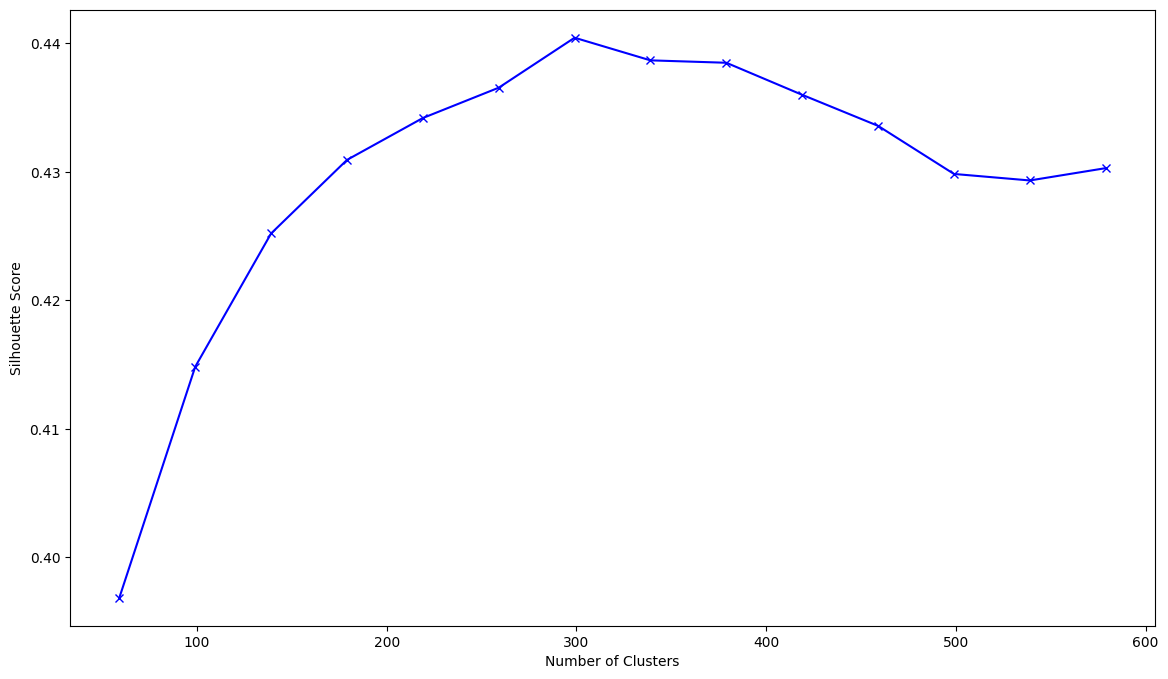

In [53]:
m.plot_selection_metric()

In [9]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Matching known entities (with character matching)...


100%|██████████| 26386/26386 [00:02<00:00, 10274.71it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 26386/26386 [01:18<00:00, 336.54it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG1...
Matching known entities (with character matching)...


100%|██████████| 68189/68189 [00:07<00:00, 9694.29it/s] 


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 68189/68189 [03:37<00:00, 314.10it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...

Predicting entities for role: ARG2...
Matching known entities (with character matching)...


100%|██████████| 27115/27115 [00:02<00:00, 10066.43it/s]


Matching unknown entities (with clustering model)...
Computing phrase embeddings...


100%|██████████| 27115/27115 [01:23<00:00, 325.54it/s]


Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...
Assigning labels to matches...


In [2]:
from relatio.utils import load_entities
known_entities = load_entities('entities.pkl')
top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

from relatio.utils import load_roles
postproc_roles = load_roles('postproc_roles.json')

/Users/shim-kojio/miniconda3/envs/mas_thesis/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/shim-kojio/miniconda3/envs/mas_thesis/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <C0890DAF-AD60-3E5F-A476-38A5CB42A179> /Users/shim-kojio/miniconda3/envs/mas_thesis/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <641FDF53-A831-3A7B-95BE-A5A95C6C5369> /Users/shim-kojio/miniconda3/envs/mas_thesis/lib/python3.7/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


ImportError: cannot import name 'QuantStub' from 'torch.ao.quantization' (/Users/shim-kojio/miniconda3/envs/mas_thesis/lib/python3.7/site-packages/torch/ao/quantization/__init__.py)

In [ ]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'hdbscan',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1', 'ARG2'],
    roles_with_known_entities = ['ARG0','ARG1','ARG2'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'character_matching',
    roles_with_unknown_entities = ['ARG0','ARG1','ARG2'],
    threshold = 0.3,
    # embeddings_model='multilingual_BERT'
)    
             
m.fit(postproc_roles, progress_bar = True) 

Matching known entities (with character matching)...


100%|██████████| 8997/8997 [00:00<00:00, 17864.27it/s]


Matching known entities (with character matching)...


100%|██████████| 29027/29027 [00:01<00:00, 17641.10it/s]


Matching known entities (with character matching)...


100%|██████████| 15879/15879 [00:00<00:00, 16667.75it/s]


Computing phrase embeddings...


100%|██████████| 34624/34624 [02:03<00:00, 279.77it/s]


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...


ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

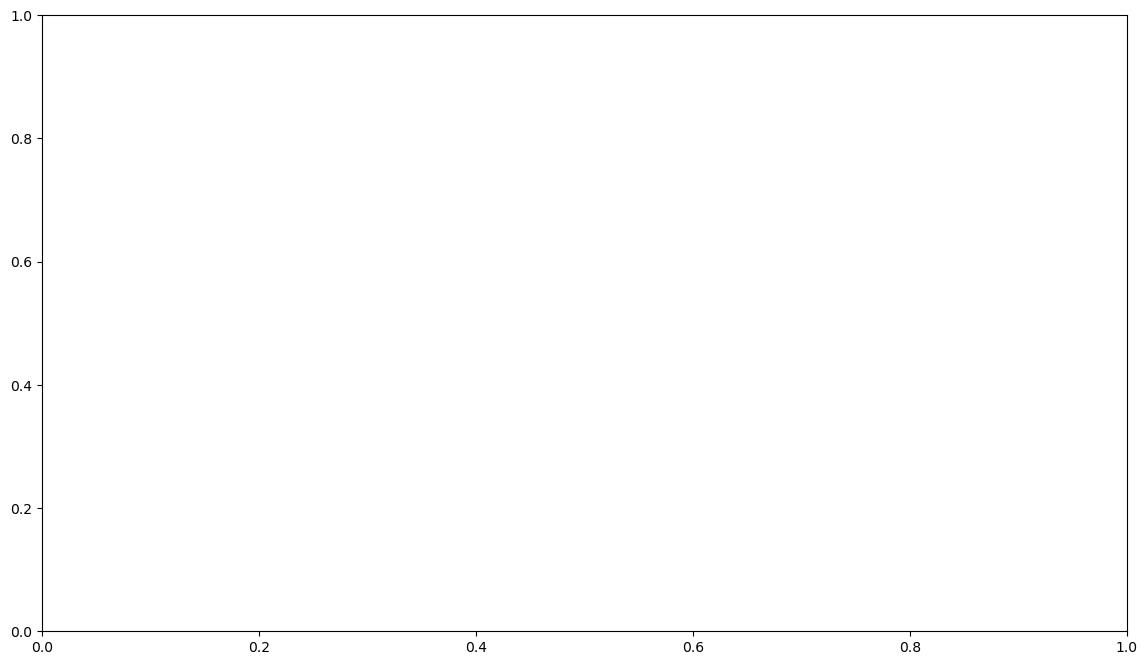

In [ ]:
m.plot_selection_metric()

In [14]:
# !python3.7 -m pip uninstall umap -y
!python3.7 -m pip uninstall umap-learn -y
!python3.7 -m pip install umap-learn==0.5.2

from umap.umap_ import UMAP